# Assignment 4

In [134]:
#Import packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn import grid_search
from sklearn import tree
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [46]:
#UDFs

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

#### Problem 1 (20 Points):

Problem 1 (20 points): Download the letter recognition data from: http://archive.ics.uci.edu/ml/datasets/Letter+Recognition  The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet. The character images were based on 20 different fonts and each letter within these 20 fonts was randomly distorted to produce a file of 20,000 unique stimuli. Each stimulus was converted into 16 primitive numerical attributes (statistical moments and edge counts) which were then scaled to fit into a range of integer values from 0 through 15. Below is the attribute information, but more information on the data and how it was used for data mining research can be found in the paper:  
P. W. Frey and D. J. Slate. "Letter Recognition Using Holland-style Adaptive Classifiers". (Machine Learning Vol 6 #2 March 91)  
Attribute Information:  
1. lettr capital letter (26 values from A to Z)  
2. x-box horizontal position of box (integer)  
3. y-box vertical position of box (integer)  
4. width width of box (integer)  
5. high height of box (integer)  
6. onpix total # on pixels (integer)  
7. x-bar mean x of on pixels in box (integer)  
8. y-bar mean y of on pixels in box (integer)  
9. x2bar mean x variance (integer)  
10. y2bar mean y variance (integer)   
11. xybar mean x y correlation (integer)  
12. x2ybr mean of x * x * y (integer)  
13. xy2br mean of x * y * y (integer)  
14. x-ege mean edge count left to right (integer)  
15. xegvy correlation of x-ege with y (integer)  
16. y-ege mean edge count bottom to top (integer)  
17. yegvx correlation of y-ege with x (integer)

Create a classification model for letter recognition using decision trees as a classification method with a holdout partitioning technique for splitting the data into training versus testing.

a. Changing the values for the depth, number of cases per parent and number of cases per leaf produces different tree configurations with different accuracies for training and testing. Choose at least five different configurations and report the accuracy for training and testing for each one of them.  Which configuration will you choose as the best model? Explain your answer.  
b. For the best tree configuration, report the misclassification matrix and interpret it.  In your opinion, is accuracy a good way to interpret the performance of the model?  If not, suggest other measures.  
c. What are the most important three attributes for recognizing the letters?

##### Problem 1-a

Given the parameters for max_depth, min_samples_split, and min_samples_leaf, the best configuration for the decision tree classifier would be max_depth = 10, min_samples_leaf = 5, min_samples_split = 10 . This configuration had the highest mean_validation_score and cv_validation_score.

In [16]:
#Import data
data_url = 'https://raw.github.com/PixarJunkie/fundamentals-of-data-science/master/data/letter_data.csv'
data_df = pd.read_csv(data_url, sep = ";")

data_df.rename(columns = {'lettr': 'label'}, inplace = True)

In [ ]:
#Features and labels
X = data_df.loc[:, data_df.columns != 'label']
y = data_df.loc[:, data_df.columns == 'label']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111)

print('X_train size: ' + str(X_train.shape))
print('X_test size: ' + str(X_test.shape))
print('y_train size: ' + str(y_train.shape))
print('y_test size: ' + str(y_test.shape))

labels = y_train.label
feature_lst = list(X_train.columns)

In [115]:
#Base decision tree 
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 23)

#Params to pass to classification model
params = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [10, 20, 30, 40, 50], 'min_samples_leaf': [5, 10, 15, 20, 25]}

#Classification model
dt_clf = grid_search.GridSearchCV(dt, param_grid = params, n_jobs = 4)
dt_clf = dt_clf.fit(X = X_train, y = labels)

predictions = dt_clf.predict(X_test)

results_df = grid_scores_to_df(clf.grid_scores_).sort_values(by = ['score'], ascending = False)

results_df.head()

,fold,max_depth,min_samples_leaf,min_samples_split,score
302,2,10,5,10,0.700021
305,2,10,5,20,0.695942
308,2,10,5,30,0.689500
320,2,10,10,20,0.689285
317,2,10,10,10,0.689285


##### Problem 1-b

The confusion matrix below shows the correctly classified cases for each label on the main diagnal, while everything else shows the count of misclassified labels for each label. Overall, the accuracy ranges from medium to high. I would say that accuracy is a good start for measuring model performance, though I would also consider exploring percision and AUC scores as well.

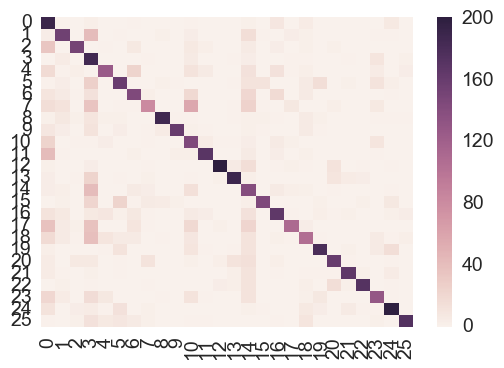

In [113]:
#Decision tree model with best configuration
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 23, max_depth = 10, min_samples_leaf = 5, min_samples_split = 10)
dt = dt.fit(X_train, y_train)

predictions = dt.predict(X_test)

#Confusion matrix plot
conf_arr = confusion_matrix(y_test, predictions)
sns.heatmap(conf_arr)

##### Problem 1-c

The three most important feature in the model are x-ege mean, y2bar mean, and y-ege mean.

In [116]:
features_df = pd.DataFrame(list(zip(X_train.columns, clf.best_estimator_.feature_importances_)), columns = ['feature label', 'feature importance']).sort_values(by = ['feature importance'], ascending = False)

features_df.head()

,feature label,feature importance
12,x-ege mean,0.167458
8,y2bar mean,0.129838
14,y-ege mean,0.113367
13,xegvy,0.108774
11,xy2br mean,0.095337


#### Problem 2 (20 Points):

On the same data from Problem 1, apply a K-nearest neighbor (kNN) classifier to classify the data.  Report the following: 

a. If you are doing any data transformation, explain the transformation and why it is needed.  
b. Report the misclassification matrix and the appropriate performance metrics for different values of K (K=1, 3, 5, and 7).  
c. Interpret the results and also compare them with the ones obtained by using the decision trees.

##### Problem 2-a

From looking at the histograms for the features, I'm not going to transform anything initially.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000155600905F8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000155C40D7860>]], dtype=object)

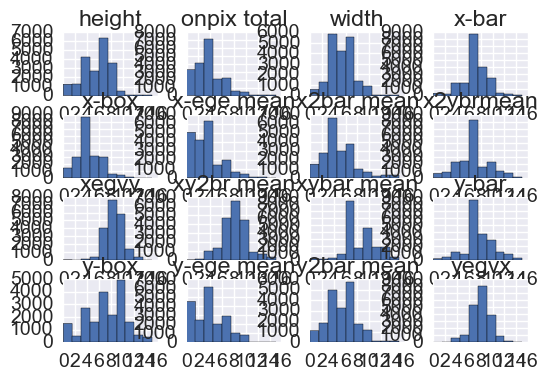

In [102]:
data_df.hist()

##### Problem 2-b

Confusion matrix below. The classification_report for K = 1,3,5,7 show a high level of accuracy, precision, and recall. 

In [117]:
#Base KNN 
knn = KNeighborsClassifier()

#Params to pass to classification model
params = {'n_neighbors': [1, 3, 5, 7], 'weights': ['uniform', 'distance']}

#Classification model
knn_clf = grid_search.GridSearchCV(knn, param_grid = params)
knn_clf = knn_clf.fit(X = X_train, y = labels)

predictions = knn_clf.predict(X_test)

results_df = grid_scores_to_df(knn_clf.grid_scores_).sort_values(by = ['score'], ascending = False)

results_df.head()

,fold,n_neighbors,score,weights
9,0,3,0.945466,distance
0,0,1,0.945252,uniform
3,0,1,0.945252,distance
4,1,1,0.944933,distance
1,1,1,0.944933,uniform


In [129]:
k = [1, 3, 5, 7]

for n in k: 
    knn = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    
    print('k = %d: ' %(n) + 'accuracy: ' + str(accuracy_score(y_test, predictions)))
    print('k = %d: ' %(n) + 'mertics:')
    print(str(classification_report(y_test, predictions)))

k = 1: accuracy: 0.9495
k = 1: mertics:
             precision    recall  f1-score   support

          A       1.00      0.99      0.99       219
          B       0.91      0.92      0.91       233
          C       0.98      0.97      0.97       217
          D       0.91      0.94      0.93       218
          E       0.92      0.93      0.92       228
          F       0.93      0.90      0.92       255
          G       0.96      0.92      0.94       243
          H       0.90      0.85      0.87       248
          I       0.96      0.98      0.97       232
          J       0.98      0.94      0.96       209
          K       0.87      0.91      0.89       204
          L       0.99      0.97      0.98       234
          M       0.99      0.98      0.98       246
          N       0.97      0.98      0.98       247
          O       0.94      0.96      0.95       227
          P       0.91      0.93      0.92       222
          Q       0.97      0.95      0.96       247
     

0.954333333333


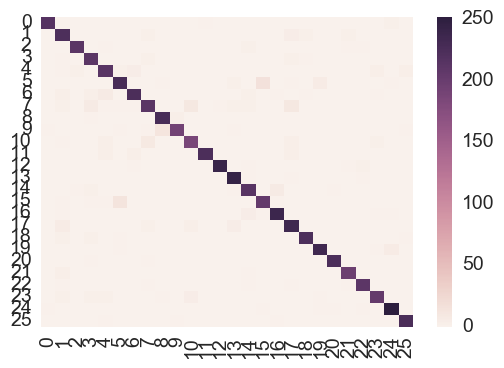

In [111]:
#KNN with best configuration
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
knn.fit(X_train, y_train)

#KNN predictions
predictions = knn.predict(X_test)

#Confusion matrix plot

print(accuracy_score(y_test, predictions))

conf_arr = confusion_matrix(y_test, predictions)
sns.heatmap(conf_arr)

##### Probelm 2-c

The results from the KNN classifier show better performance than the decision tree classifier. KNN has higher accuracy, and the confusion matrix shows that it is also more successful in correct predictions.

#### Problem 3 (30 Points):

For this problem, we will be doing clustering on the seeds dataset, which you must download from http://archive.ics.uci.edu/ml/datasets/seeds# 
The examined data group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for the experiment. High quality imaging of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.   
Attribute information – seven geometric parameters of wheat kernels were measured:  
1. area A,  
2. perimeter P,  
3. compactness C = 4*pi*A/P^2,  
4. length of kernel,  
5. width of kernel,  
6. asymmetry coefficient   
7. length of kernel groove. 

All of these attributes are numeric, continuously varied variables. The last attribute in the data file represents the class label. 

a. (15 points)   
1. In k-means how are the cluster centers calculated?  
2. Name two similarity measures (or distance functions) and what type of data you would use them for.  

3. Perform k-means clustering using all the attributes except the class label.  Use multiple numbers of clusters (k=3, 4, 5, and 6). For each k: 
        i. Report the final cluster centers 
        ii. Report the number of elements in each cluster 
        iii. Report the class distribution within each cluster (use crosstab between      labels and cluster membership) 
        iv. Export to a variable (but do not report) the distance of each point from its cluster.    
4. Using the information you gathered (particularly (iv)), choose the best number of clusters by doing an unsupervised analysis. Specifically, create a graph (in Excel or Google Docs, etc.) of the total error per number of clusters and find the ‘knee’. See the last lab for details. Which k do you choose? 

5. Also choose the best number of clusters by doing an analysis that takes advantage of the labels, by looking at the results of (iii) above.  Which k would you choose?  
6. For the selected k in (iv), analyze and report if the normalization of the attributes will influence the clustering results.  

b. (10 points) Perform hierarchical clustering using all attributes except the class label as follows:  

    1. Apply single linkage algorithm and report 
             i. The dendogram (copy and paste the image and scale it to a single page)  
             ii. The class distribution at the level of the dendogram where there are only   three clusters. 
    2. Apply complete linkage and report 
             i. The dendogram (copy and paste the image and scale it to a single page) 
             ii. The class distribution at level of the dendogram where there are only three clusters.  
c. (5 points) Create an executive summary (~half a page) that summarizes what this data analysis has shown.  Include an explanation of what it means to cluster this data, describe the methods used, summarize and compare the results of the methods, and makes any applicable recommendations.  When creating it, imagine that you will give this summary to someone who is not an expert in data mining

##### Problem 3-a

1. Cluster centers are calculated as the mean value of the points within the cluster.
2. Two main similariy measures are the euclidean and cosine similarities. Cosine similarity works best when used in situations where magnitude of data points within a cluster do not matter. 

In [144]:
#Import data
seeds_url = 'https://github.com/PixarJunkie/fundamentals-of-data-science/raw/master/data/seeds_dataset.txt'
seeds_df = pd.read_table(seeds_url)

In [145]:
seeds_df

,,,,,,,area perimeter compactness length width asymmetry groove_length label
15.26,14.84,0.8710,5.763,3.312,2.2210,5.220,1
14.88,14.57,0.8811,5.554,3.333,1.0180,4.956,1
14.29,14.09,0.9050,5.291,3.337,2.6990,4.825,1
13.84,13.94,0.8955,5.324,3.379,2.2590,4.805,1
16.14,14.99,0.9034,5.658,3.562,1.3550,5.175,1
14.38,14.21,0.8951,5.386,3.312,2.4620,4.956,1
14.69,14.49,0.8799,5.563,3.259,3.5860,5.219,1
14.11,14.10,0.8911,5.420,3.302,2.7000,5.000,1
16.63,15.46,0.8747,6.053,3.465,2.0400,5.877,1
16.44,15.25,0.8880,5.884,3.505,1.9690,5.533,1
